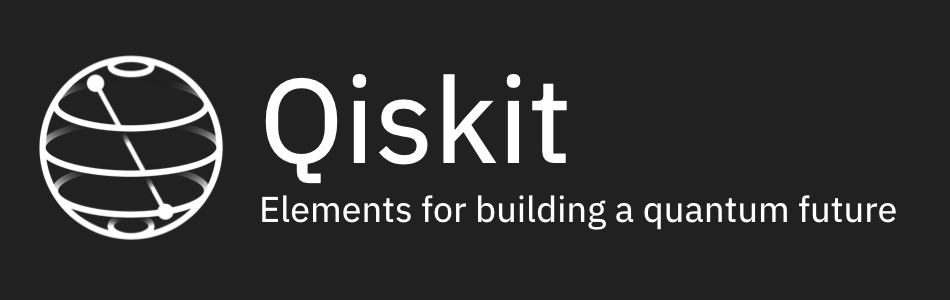

# Calibrating a two qubit gate

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

In the previous [tutorial](1a_calibrating_a_qubit.ipynb) we demonstrated how to control a single-qubit device with pulse and calibrate a single qubit gate. In this tutorial we will calibrate a two-qubit gate with a cross-resonance pulse using `ibmq_almaden`, a 20 qubit client-only system.

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_johannesburg')

backend_config = backend.configuration()

In [3]:
config = backend.configuration()
defaults = backend.defaults()

# Measuring CR Rabi oscillation

In this section, we measure cross resonance Rabi oscillation on qubit0 and qubit1. The basic idea of a cross resonance gate is to apply a microwave pulse to the control qubit at the frequency of the target qubit resonance frequency. For more information, see this [paper](https://arxiv.org/abs/1603.04821). As the frequency of the drive channel used in previous experiments is adjusted to be at the resonance frequency of corresponding qubit, a cross resonance pulse must be applied from another channel so that a different frequency may be used for the pulse. This is why we use a control channel (`U channel`) in this experiment.  
It should be noted that the role of control channels is not only applying CR pulses, but any possible Hamiltonian term as described in `config.hamiltonian`, and consequently the effect of `ControlChannel` stimulus strongly depends on the design of the specific quantum computing backend.

In [4]:
# qubit to use for exeperiment
control_qubit = 1
target_qubit = 0
control_channel_index = 1

# exp configuration
exps = 30
shots = 512

# Rabi pulse
cr_amps = np.linspace(0, 0.2, exps)
cr_samples = 200
cr_sigma = 4
cr_rise_fall = 16

# scaling factor for data returned by backend
# note: You may have to adjust this for the backend you use
scale_factor= 1e-14

You can check if your control qubit and target qubit are connected by bus

In [5]:
[control_qubit, target_qubit] in config.coupling_map

True

Usually we use a qubit with higher frequency as a control.

In [6]:
defaults.qubit_freq_est[control_qubit] > defaults.qubit_freq_est[target_qubit]

/anaconda3/envs/qiskit14/lib/python3.7/site-packages/qiskit/providers/models/pulsedefaults.py:155: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '


True

For the above qubit configuration, control channel 0 is available to realize a CR pulse. For other configurations, you can refer to the `InstructionScheduleMap` which may be found in `defaults.circuit_instruction_map` to find the proper control channel index.

In [7]:
config.u_channel_lo[control_channel_index]

[UchannelLO(q=5, scale=(1+0j))]

In this experiment, we use two-pulse echoed CR sequence to eliminate unwanted interactions.

In [8]:
# Create schedule
schedules = []
for ii, cr_amp in enumerate(cr_amps):
    # drive pulse
    cr_rabi_pulse_p = pulse_lib.gaussian_square(duration=cr_samples,
                                                amp=cr_amp,
                                                sigma=cr_sigma,
                                                risefall=cr_rise_fall,
                                                name='cr_rabi_pulse_p%d' % ii)
    cr_rabi_pulse_m = pulse_lib.gaussian_square(duration=cr_samples,
                                                amp=-cr_amp,
                                                sigma=cr_sigma,
                                                risefall=cr_rise_fall,
                                                name='cr_rabi_pulse_m%d' % ii)
    
    control_channel = pulse.ControlChannel(control_channel_index)
    
    # We get the state preparation and measurement pulses we need from the
    # defaults `circuit_instruction_map`
    pi_pulse_q0 = defaults.circuit_instruction_map.get('u3', (control_qubit,), np.pi, 0, np.pi)
    measure = defaults.circuit_instruction_map.get('measure', config.meas_map[0])
    
    # add commands to schedule
    schedule = pulse.Schedule(name='CR Rabi Experiment at drive amp = %s' % cr_amp)
    
    schedule |= cr_rabi_pulse_p(control_channel)
    schedule |= pi_pulse_q0 << schedule.duration
    schedule |= cr_rabi_pulse_m(control_channel) << schedule.duration
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

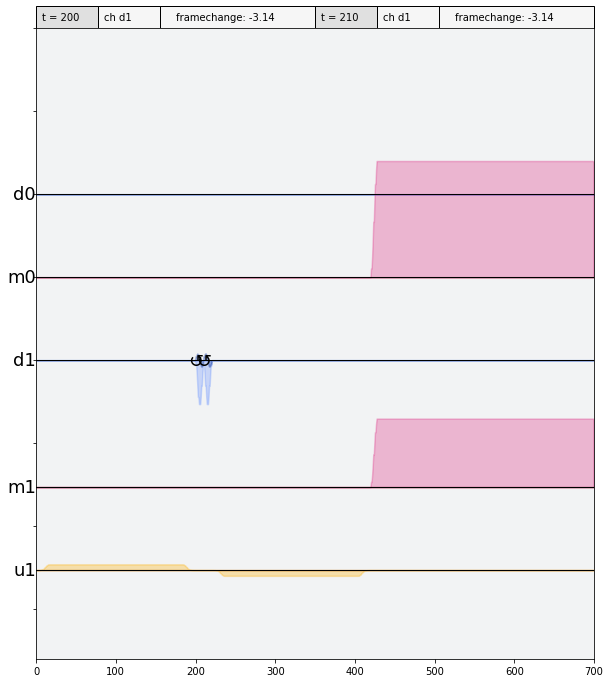

In [13]:
schedules[1].draw(channels_to_plot=[pulse.DriveChannel(control_qubit),
                                    pulse.DriveChannel(target_qubit),
                                    control_channel,
                                    pulse.MeasureChannel(control_qubit),
                                    pulse.MeasureChannel(target_qubit)],
                   scaling=10.0, label=False, plot_range=(0, 700))

In [9]:
cr_rabi_qobj = assemble(schedules, backend, meas_level=MeasLevel.KERNELED, 
                        meas_return=MeasReturnType.AVERAGE, shots=shots)

In [10]:
job = backend.run(cr_rabi_qobj)

In [11]:
job.job_id()

'5e31bf8e0520030011cbdb08'

In [12]:
job.status()

<JobStatus.VALIDATING: 'job is being validated'>

In [13]:
cr_rabi_result = job.result(timeout=3600)

In [14]:
job = backend.retrieve_job('5e31bf8e0520030011cbdb08')
cr_rabi_results = job.result(timeout=120)

### Analyze the result

In [15]:
target_qubit_rabi_data = np.ones(exps, dtype=np.complex_)
control_qubit_rabi_data = np.ones(exps, dtype=np.complex_)

for i in range(exps):
    target_qubit_rabi_data[i] = cr_rabi_result.get_memory(i)[target_qubit]
    control_qubit_rabi_data[i] = cr_rabi_result.get_memory(i)[control_qubit]

As expected below we can observe the oscillation of the measured signal of only the target qubit.

In [16]:
# auto-phase the output measurement signal

def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

0.027191350692821387


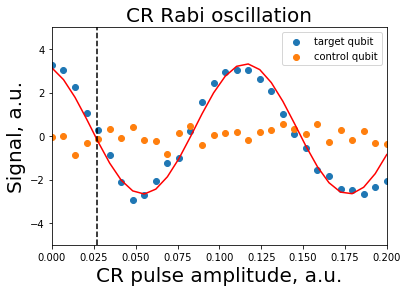

In [23]:
target_rabi_amp_data = get_amplitude(target_qubit_rabi_data)*scale_factor
control_rabi_amp_data = get_amplitude(control_qubit_rabi_data)*scale_factor

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, cr_amps, target_rabi_amp_data, [3.0,0.0,0.1,0])

#get the pi amplitude
cr_pi_2_amp = (np.pi-fitparams[3])*fitparams[2]/4/np.pi

plt.plot(cr_amps, fit_func(cr_amps, *fitparams), color='red')
plt.axvline(cr_pi_2_amp, color='black', linestyle='dashed')
plt.scatter(cr_amps, target_rabi_amp_data, label='target qubit')
plt.scatter(cr_amps, control_rabi_amp_data, label='control qubit')
plt.xlim(0, 0.2)
plt.ylim(-5, 5)
plt.legend()
plt.xlabel('CR pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('CR Rabi oscillation', fontsize=20)

print(cr_pi_2_amp)

From the fit we obtain the CR Rabi oscillation frequency. We may use this to extract the amplitude of a CR π/2 pulse, which is the foundation of the `cx`(CNOT) gate in our systems. To see the pulse schedule for a `cx` gate look in the `defaults.circuit_instruction_map`

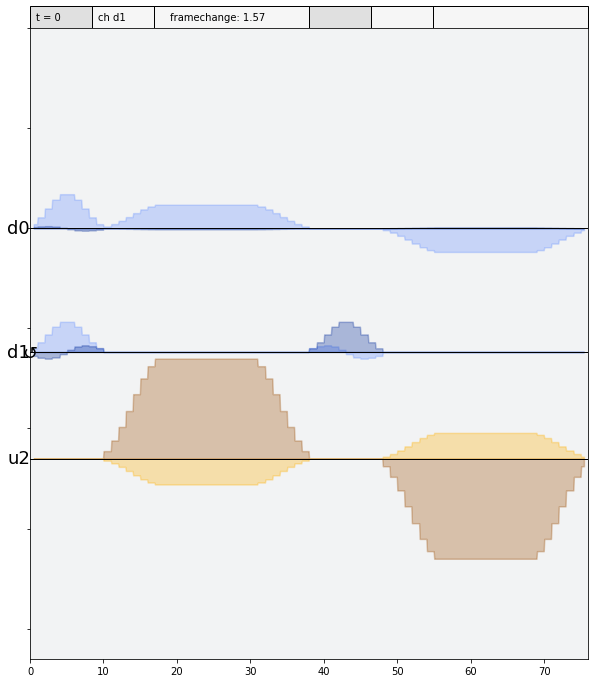

In [17]:
defaults.circuit_instruction_map.get('cx', (control_qubit, target_qubit)).draw(show_framechange_channels=False)

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright